In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier as CD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/lyrics toxicity'

In [ ]:
df = pd.read_csv(path + '/data/cleaned_df.csv')
df.head()

,seq,label,toxicity,clean_lyrics
0,"No, no\r\nI ain't ever trapped out the bando\r...",0.626,toxic,no i ever trap bando but oh lord get wrong i k...
1,"The drinks go down and smoke goes up, I feel m...",0.630,toxic,the drink go smoke go i feel get let go my car...
2,She don't live on planet Earth no more\r\nShe ...,0.240,toxic,she live planet earth she find love venus word...
3,"Trippin' off that Grigio, mobbin', lights low\...",0.536,toxic,trippin grigio mobbin light low trippin grigio...
4,"I see a midnight panther, so gallant and so br...",0.371,toxic,i see midnight panther gallant brave i find i ...


In [ ]:
df['toxicity'].loc[(df.toxicity=='toxic')] = 1

df['toxicity'].loc[(df.toxicity== 'non_toxic')] = 0  

df.head()

,seq,label,toxicity,clean_lyrics
0,"No, no\r\nI ain't ever trapped out the bando\r...",0.626,1,no i ever trap bando but oh lord get wrong i k...
1,"The drinks go down and smoke goes up, I feel m...",0.630,1,the drink go smoke go i feel get let go my car...
2,She don't live on planet Earth no more\r\nShe ...,0.240,1,she live planet earth she find love venus word...
3,"Trippin' off that Grigio, mobbin', lights low\...",0.536,1,trippin grigio mobbin light low trippin grigio...
4,"I see a midnight panther, so gallant and so br...",0.371,1,i see midnight panther gallant brave i find i ...


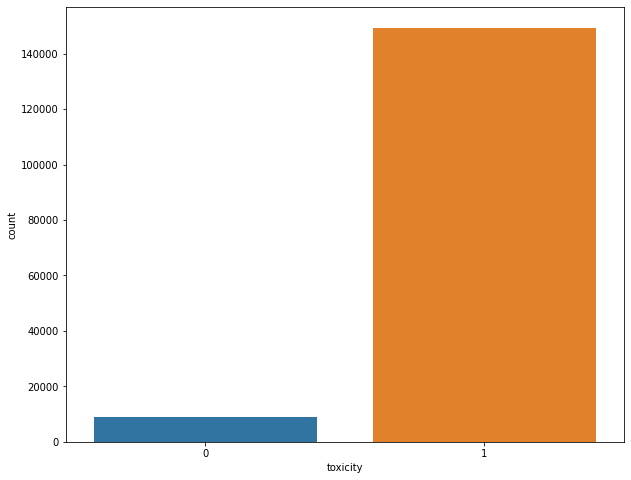

In [ ]:
plt.figure(figsize = (10, 8))
sns.countplot(df['toxicity'])
plt.show()

In [ ]:
#removing shortwords
df = df[df['clean_lyrics'].notnull()]
df.cleaned_text=df['clean_lyrics'].astype(str)
tokenized_df=df['clean_lyrics'].apply(lambda x: x.split())
tokenized_df.head(5)

0    [no, i, ever, trap, bando, but, oh, lord, get,...
1    [the, drink, go, smoke, go, i, feel, get, let,...
2    [she, live, planet, earth, she, find, love, ve...
3    [trippin, grigio, mobbin, light, low, trippin,...
4    [i, see, midnight, panther, gallant, brave, i,...
Name: clean_lyrics, dtype: object

In [ ]:
df['clean_lyrics']=df['clean_lyrics'].apply(lambda x: " ".join([w for w in x.split() if len(w)>10]))
df.toxicity.value_counts()

1    149372
0      8975
Name: toxicity, dtype: int64

In [ ]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['clean_lyrics'].values.astype('U'))

In [ ]:
from sklearn.model_selection import train_test_split
X=text_counts
y=df['toxicity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=19)

In [ ]:
print("x_train: ",X_train.shape)
print("x_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

x_train:  (126677, 11573)
x_test:  (31670, 11573)
y_train:  (126677,)
y_test:  (31670,)


In [ ]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')
y = y.astype('int')

In [ ]:
def plot_cm(y_true, y_pred,filename, figsize=(8,8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d' % (p, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=['non-toxic', 'toxic'], columns=['non-toxic', 'toxic'])
    sns.set(font_scale=2) # Adjust to fit
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "OrRd", annot=annot, fmt='', ax=ax)
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label',fontsize=18)
    plt.xticks( rotation=0, weight = 'bold')
    plt.yticks( rotation=90, weight = 'bold')
    # plt.tick_params(rotation=10,axis='x', labelsize=18)
    plt.show()
    plt.close()

In [38]:
# def Model(model,name):
#     model.fit(X_train,y_train)
#     filename = '/content/drive/MyDrive/Colab Notebooks/lyrics toxicity/model/xgb_model.sav'
#     pickle.dump(model, open(filename, 'wb'))
#     model_train_score = model.score(X_train, y_train)
#     model_test_score = model.score(X_test, y_test)
#     prediction = model.predict(X_test)
#     print('{} Trainng Score {}\n'.format(name,model_train_score))
#     print('{} Testing Score {}\n'.format(name,model_test_score))
#     plot_cm(y_test, prediction,name)
#     return model_train_score, model_test_score, prediction

In [41]:

# load the model from disk
# loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/lyrics toxicity/model/xgb_model.sav', 'rb'))
# result = loaded_model.score(X_test, y_test)
# print(result)

0.9428165456267761


In [42]:
def Model(model,name):
    model.fit(X_train,y_train)
    model_train_score = model.score(X_train, y_train)
    model_test_score = model.score(X_test, y_test)
    prediction = model.predict(X_test)
    print('{} Trainng Score {}\n'.format(name,model_train_score))
    print('{} Testing Score {}\n'.format(name,model_test_score))
    plot_confusion_matrix(model,X_test,y_test,cmap="magma")
    return model, model_train_score, model_test_score, prediction


Multinomial Naive Bayes Trainng Score 0.9441413989911349

Multinomial Naive Bayes Testing Score 0.9282917587622356



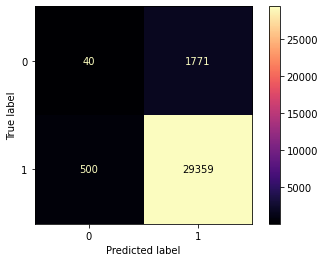

In [ ]:
MNB = MultinomialNB(alpha=0.15,fit_prior=True, class_prior=None)
MNB_model = Model(MNB,"Multinomial Naive Bayes")

SGD classifier Trainng Score 0.9437309061629183

SGD classifier Testing Score 0.9427218187559204



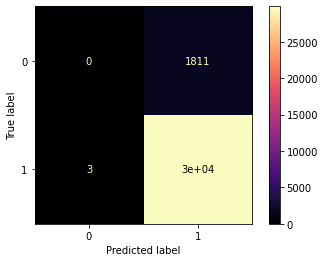

In [ ]:
SGD = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, random_state=42, max_iter=200, tol=None)
SGD_model = Model(SGD,"SGD classifier")

Randomforrenst classifier Trainng Score 0.9491936184153398

Randomforrenst classifier Testing Score 0.9407009788443321



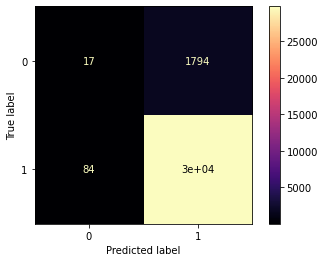

In [ ]:
RF = RandomForestClassifier(n_estimators=100,criterion ='entropy')
RF_model = Model(RF,"Randomforrenst classifier")

XGB classifier Trainng Score 0.9434467188203067

XGB classifier Testing Score 0.9428165456267761



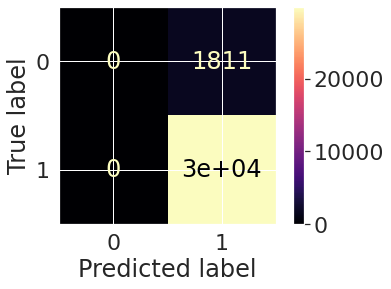

In [43]:
# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
XGB_model = Model(xgb, "XGB classifier")

Cat Boost Classifier Trainng Score 0.9434467188203067

Cat Boost Classifier Testing Score 0.9428165456267761



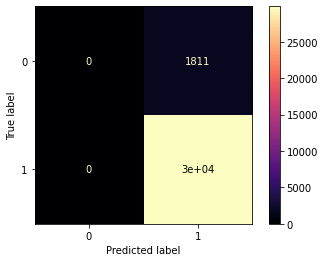

In [ ]:
# catboost
cbc = CD(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cat_model = Model(cbc,"Cat Boost Classifier")

In [ ]:
MLA = {
     'MNB' : MNB,
     'SGD' : SGD,
     'XGB' : xgb,
     'Cat' : cbc,
}

In [ ]:
from sklearn.metrics import *
columns = []
compare = pd.DataFrame(columns = columns)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=4
row_index = 0
for name,alg in MLA.items():
    MLA_name = name
    predicted = alg.predict(X_test)
    micro_averaged_recall = recall_score(y_test, predicted, average = 'micro')
    maicro_averaged_f1 = f1_score(y_test, predicted, average = 'micro')
    precisions =precision_score(y_test, predicted, average = 'micro')
    compare.loc[row_index,'Name'] = MLA_name
    compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    compare.loc[row_index, 'Precision'] = precisions
    compare.loc[row_index, 'Recall'] = micro_averaged_recall
    compare.loc[row_index, 'F1 Score'] = maicro_averaged_f1
    row_index+=1
    
compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
compare


,Name,Test Accuracy,Precision,Recall,F1 Score
2,XGB,0.9428,0.942817,0.942817,0.942817
3,Cat,0.9428,0.942817,0.942817,0.942817
1,SGD,0.9427,0.942722,0.942722,0.942722
0,MNB,0.9283,0.928292,0.928292,0.928292


In [ ]:
compare.to_csv(path+'/data/ml_result.csv', index =False)

In [ ]:
#plot comaparison 
def compare_plots(y_value,filename):
  plt.subplots(figsize=(11,8))
  sns.barplot(x="Name", y=y_value ,data=compare,palette='hot',hue="Name",edgecolor=sns.color_palette('dark',7),dodge=False)
  plt.xlabel('Algorithms',fontsize=20)
  plt.ylabel(y_value,fontsize=20)
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=20)
  plt.tick_params(rotation=0,axis='x', labelsize=20)
  plt.title('Comparing techniques with '+y_value+'.',fontsize=22)
  plt.legend(loc = 2, bbox_to_anchor = (1,1),prop={'size': 20})
  return plt

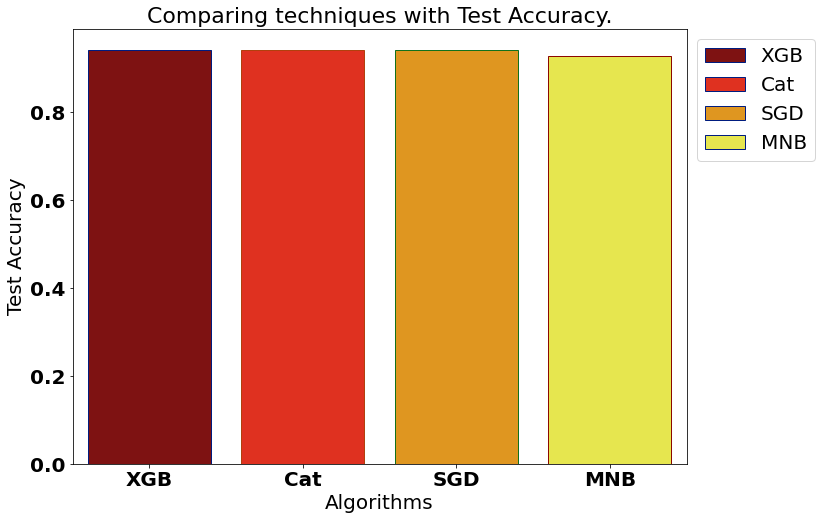

In [ ]:
compare_plots("Test Accuracy","Test Accuracy");